# Gradient descent density matrix learning
Created 08/05/2024

Objectives:
* As seen in [this notebook](gradient_descent.ipynb), gradient descent is struggling with learning the solution, but fine with unitarizing. However we know the solution is a unitarized version of the density matrix. So can we learn the density matrix first, then unitarize?

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
from functools import reduce
from operator import mul
from collections import namedtuple

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

import scipy

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [8]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [9]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [10]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [11]:
psi = loaded_data_non_triv_proj_rep[0.45]

# Definitons

In [12]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [13]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [14]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [15]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [16]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [17]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [18]:
fermionic_np_symmetries = [np_I, np_JW]

In [19]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [20]:
npc_JW = fermionic_npc_symmetries[1]

In [21]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [22]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [23]:
s = symmetry_actions[0][1]

case = SymmetryActionWithBoundaryUnitaries(
    psi,
    s*40,
    left_symmetry_index=60,
    left_boundary_unitaries=[np_I, np_00]*1,
    right_boundary_unitaries=[np_00, np_I]*1
)

In [24]:
case.compute_svd_approximate_expectation()

(-7.171141509766298e-28-4.647688751856734e-31j)

## Functions

In [25]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [26]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [27]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [28]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [29]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

In [30]:
l = list(range(10))

In [31]:
def contracted_right_tensors_mpo(w_tensors_1, w_tensors_2):
    out = list()

    out.append(t)

    # First site
    w1 = w_tensors_1[-1].replace_label('vL', 'vL1')
    w2 = w_tensors_2[-1].replace_label('vL', 'vL2')
    
    t = npc.tensordot(w1, w2, [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    # Inner sites
    for w1, w2 in zip(w_tensors_1[-2::-1], w_tensors_1[-2::-1]):
        w1 = w1.replace_label('vL', 'vL1')
        w2 = w2.replace_label('vL', 'vL2')
        t = npc.tensordot(t, w1, [['vL1',], ['vR',]])
        t = npc.tensordot(
            t,
            w2,
            [['vL2', 'p', 'p*'], ['vR', 'p*', 'p']]
        )
  
        out.append(t)

    return out[::-1]

### Initialize tensors

In [32]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [33]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [34]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [35]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [36]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [37]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [38]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [39]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [40]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [41]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [42]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [74]:
def mpo_rdm_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    COMMENT!
    
    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_contracted_mpo_tensors = unitary_order_two_right_tensors(mpo_tensors)
    #right_overlap_tensors = overlap_right_tensors(mpo_tensors, b_tensors)
    
    left_contracted_mpo_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_contracted_mpo_tensors[0]

    # MPO terms
    # Below line should break? Bad leg indices?
    grad_mpo = npc.tensordot(t, w, [['vL'], ['vR',]])

    grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment.conj(), [['vL', 'vL*'], ['vR', 'vR*']])
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)
    
    # Can these add? Do they have the same leg index?
    #print(grad_mpo)
    #print(grad_o)
    grad = grad_mpo - grad_o

    """
    score=update_mpo_score(
        grad,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    """
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_contracted_mpo_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment.conj(), [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_contracted_mpo_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_contracted_mpo_tensors[-1]

        grad_mpo = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_mpo = npc.tensordot(grad_mpo, left_two_tensor, [['vL'], ['vR',]])

        grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (grad_mpo - grad_o)

        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_contracted_mpo_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_contracted_mpo_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_mpo = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (grad_mpo - grad_o)
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """

    score = 0
    for g in grads:
        X = g.to_ndarray()
        out = np.sum(X*(X.conj()))
        score += out
    
    return (grads, score)

In [58]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, unitarity_learning_rate, overlap_learning_rate,
    overlap_target, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)


    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """
    
    return (grads, unitary_score, c_abs)

In [59]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [60]:
def two_sided_mpo_rdm_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, symmetry_transfer_matrix, left_adam_optimizers,
    right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, score = mpo_rdm_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_  = mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return score

In [61]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_ = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [62]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [63]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [64]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params):
    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(
            symmetry_case.left_symmetry_index - 1,
            symmetry_case.left_symmetry_index - 1 - num_sites, -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b) for b in left_b_tensors
    ]

    right_physical_dims = [
        get_physical_dim(b) for b in right_b_tensors
    ]
    
    right_total_dimension = reduce(mul, right_physical_dims)

    left_physical_dims = [
        get_physical_dim(b) for b in left_b_tensors
    ]

    left_total_dimension = reduce(mul, left_physical_dims)

    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    right_mpo_tensors = get_random_mpo_tensors(
        right_physical_dims,
        virtual_dims
    )
    left_mpo_tensors = get_random_mpo_tensors(
        left_physical_dims,
        virtual_dims
    )
    rescale_mpo_tensors(right_mpo_tensors, 1)
    rescale_mpo_tensors(left_mpo_tensors, 1)

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [65]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [66]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [67]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [68]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Test

## 1

In [93]:
num_iterations = 2500

num_sites = 4
bond_dimension=6
adam_params = (5e-4, 0.35, 0.35)

In [94]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

scores = list()

for _ in range(num_iterations):
    score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    scores.append(score)

end = time.time()
print(end - start)

78.25067114830017


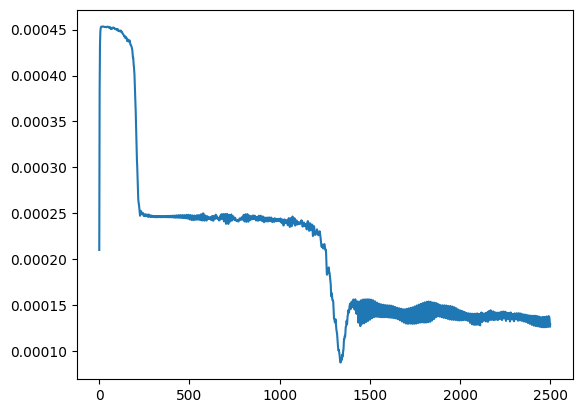

In [95]:
plt.plot(scores)

Now plug into unitary solver...

In [96]:
start = time.time()

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

138.98247408866882


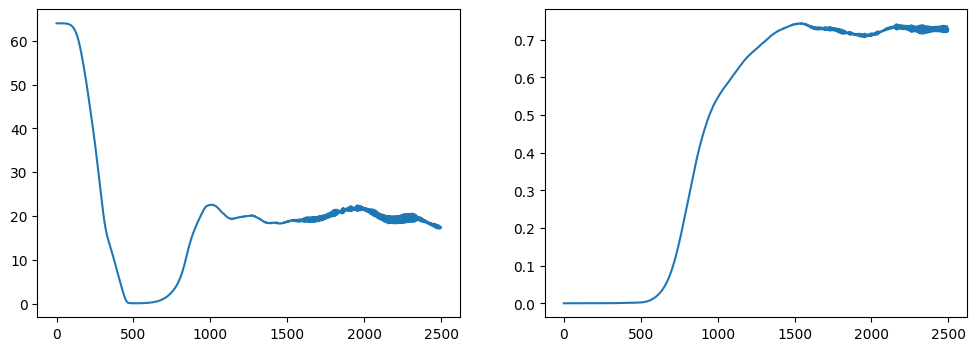

In [97]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

## 2

In [98]:
num_iterations = 2500

num_sites = 6
bond_dimension=8
adam_params = (5e-4, 0.35, 0.35)

In [99]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

scores = list()

for _ in range(num_iterations):
    score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    scores.append(score)

end = time.time()
print(end - start)

86.74757122993469


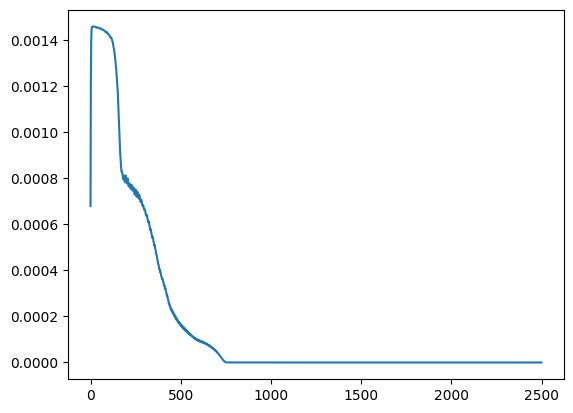

In [100]:
plt.plot(scores)

Now plug into unitary solver...

In [101]:
start = time.time()

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

445.8958239555359


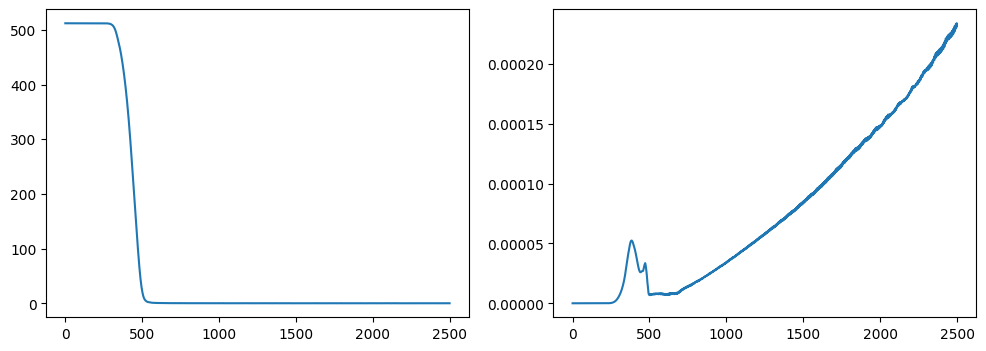

In [102]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [103]:
start = time.time()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

363.68734979629517


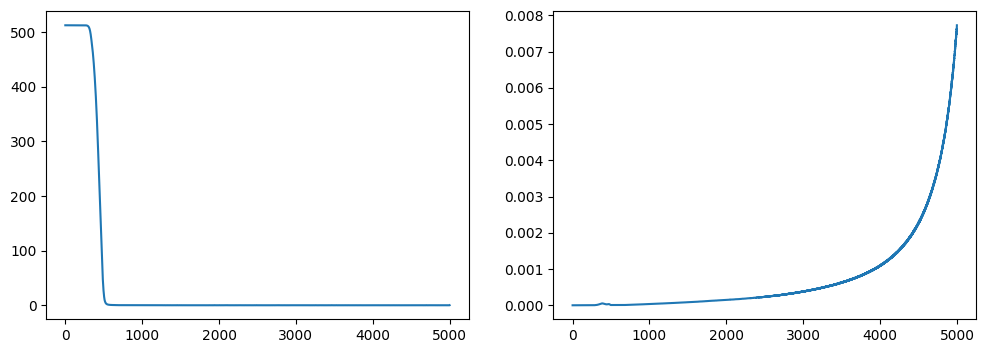

In [104]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

## 3

In [105]:
num_iterations = 2500

num_sites = 6
bond_dimension=7
adam_params = (8e-4, 0.37, 0.37)

In [106]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

scores = list()

for _ in range(num_iterations):
    score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    scores.append(score)

end = time.time()
print(end - start)

98.00915908813477


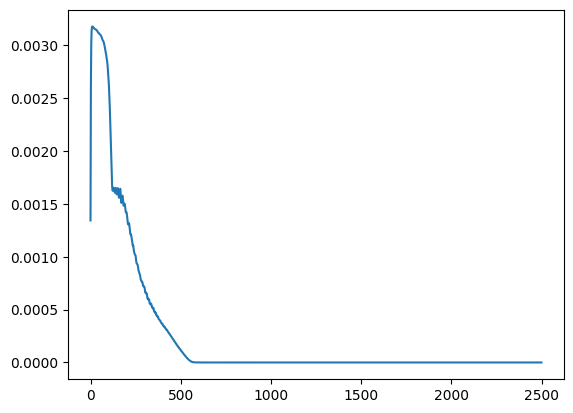

In [107]:
plt.plot(scores)

Now plug into unitary solver...

In [108]:
start = time.time()

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

303.7569999694824


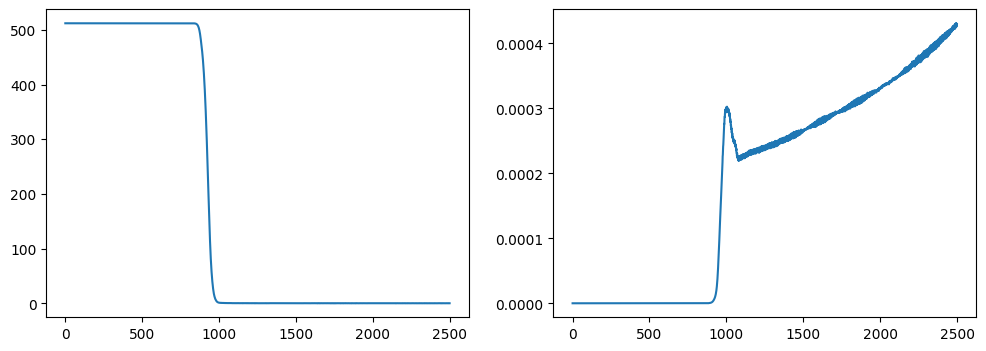

In [109]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [110]:
start = time.time()

for _ in range(6*num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

1481.9784886837006


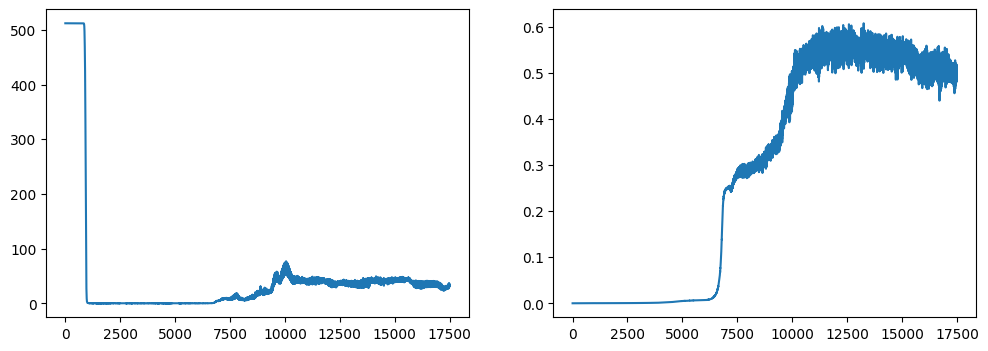

In [111]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [112]:
right_total_dimension

512

# Conclusion
Doesn't seem to be working as intended, but without checking the error of the MPO and density matrix, we don't even know if the first step is working. This should be done first!